<h1>SVHN Classification using CNNs</h1>

---



# Importing Keras Modules


In [1]:
#Importing important modules
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Loading the Dataset

<h3>Import train and test sets of  SVHN dataset</h3>

In [3]:
import h5py
import numpy as np

# Open the file as readonly
h5f = h5py.File('/content/gdrive/My Drive/Colab Notebooks/SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
x_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()


<h4>Visualizing the dataset</h4>

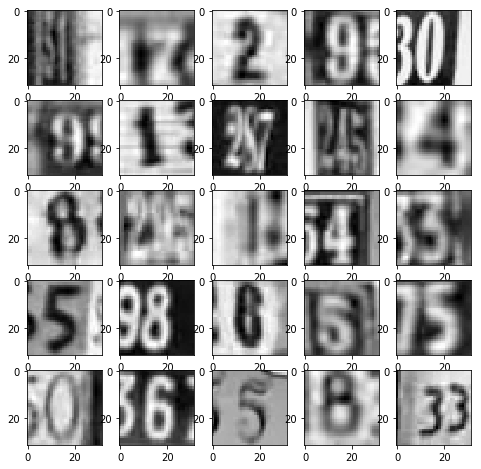

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(0, columns*rows):
    img = x_test[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap='gray')
plt.show()

In [5]:
y_test[:25]

array([1, 7, 2, 9, 0, 9, 1, 8, 4, 4, 8, 9, 1, 4, 3, 5, 8, 6, 5, 5, 0, 6,
       5, 8, 3], dtype=uint8)

In [6]:
x_train.shape

(42000, 32, 32)

In [7]:
#Importing opencv module for the resizing function
import cv2

#Create a resized dataset for training and testing inputs with corresponding size. Here we are resizing it to 28X28 (same input size as MNIST)
x_train_res = np.zeros((x_train.shape[0],28,28), dtype=np.float32)
for i in range(x_train.shape[0]):
  #using cv2.resize to resize each train example to 28X28 size using Cubic interpolation
  x_train_res[i,:,:] = cv2.resize(x_train[i], dsize=(28, 28), interpolation=cv2.INTER_CUBIC)

x_test_res = np.zeros((x_test.shape[0],28,28), dtype=np.float32)
for i in range(x_test.shape[0]):
  #using cv2.resize to resize each test example to 28X28 size using Cubic interpolation
  x_test_res[i,:,:] = cv2.resize(x_test[i], dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
  
#We don't need the original dataset anynmore so we can clear up memory consumed by original dataset
del x_train
del x_test

print(x_train_res.shape)
print(x_test_res.shape)

(42000, 28, 28)
(18000, 28, 28)


<h3>Reshape train and test sets into shapes compatible with keras models</h3>

<h4>Keras expects data to be in the format (N_E.N_H,N_W,N_C)  N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.</h4>


In [8]:
# input image dimensions
img_rows, img_cols = 28, 28


#Keras expects data to be in the format (N_E.N_H,N_W,N_C)  N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.
x_train = x_train_res.reshape(x_train_res.shape[0], img_rows, img_cols, 1)
x_test = x_test_res.reshape(x_test_res.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [9]:
x_train_res.shape

(42000, 28, 28)

<h3>Pre-processing the dataset</h3>
<h4>Normalizing the input</h4>

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Normalizing the input
x_train /= 255.0
x_test /= 255.0
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (42000, 28, 28, 1))
(42000, 'train samples')
(18000, 'test samples')


In [11]:
batch_size = 128
num_classes = 10
epochs = 12

<h4>Convert Labels from digits to one hot vectors</h4>

In [12]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train[0])

# Building the CNN 

<h4>Define the layers of model</h4> 

In [13]:
#Initialize the model
model = Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(64, (3, 3), activation='relu'))

#Add a MaxPooling Layer of size 2X2 
model.add(MaxPooling2D(pool_size=(2, 2)))

#Apply Dropout with 0.25 probability 
model.add(Dropout(0.25))

#Flatten the layer
model.add(Flatten())

#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
model.add(Dense(128, activation='relu'))

#Apply Dropout with 0.5 probability 
model.add(Dropout(0.5))

#Add Fully Connected Layer with 10 units and activation function as 'softmax'
model.add(Dense(num_classes, activation='softmax'))

<h4>Set Adam Optimizer and Loss function for training</h4> 

In [14]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

#To use adam optimizer for learning weights with learning rate = 0.001
optimizer = Adam(lr=0.001)
#Set the loss function and optimizer for the model training
model.compile(loss=categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

# Training the CNN 

<h4>Initializing Early stopping and Model chekpoint callbacks </h4>

In [15]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('svhn_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

<h4>Fit the model to the dataset</h4>

In [16]:
#Training on the dataset and adding the all the callbacks to the fit function.
#Once the training starts, results start appearing on Tensorboard after 1 epoch
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping,model_checkpoint])

Train on 42000 samples, validate on 18000 samples
Epoch 1/12
42000/42000 [==============================] - 6s 150us/step - loss: 1.4251 - accuracy: 0.5318 - val_loss: 0.7061 - val_accuracy: 0.8021

Epoch 00001: val_loss improved from inf to 0.70615, saving model to svhn_cnn_checkpoint_01_loss0.7061.h5
Epoch 2/12
42000/42000 [==============================] - 4s 88us/step - loss: 0.7817 - accuracy: 0.7617 - val_loss: 0.5513 - val_accuracy: 0.8434

Epoch 00002: val_loss improved from 0.70615 to 0.55126, saving model to svhn_cnn_checkpoint_02_loss0.5513.h5
Epoch 3/12
42000/42000 [==============================] - 4s 88us/step - loss: 0.6676 - accuracy: 0.7980 - val_loss: 0.5523 - val_accuracy: 0.8450

Epoch 00003: val_loss did not improve from 0.55126
Epoch 4/12
42000/42000 [==============================] - 4s 87us/step - loss: 0.6088 - accuracy: 0.8140 - val_loss: 0.4651 - val_accuracy: 0.8652

Epoch 00004: val_loss improved from 0.55126 to 0.46511, saving model to svhn_cnn_checkpoint_

# Evaluating the CNN

<h4>Evaluate trained model on the test set</h4>

In [17]:
#Testing the model on test set
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

18000/18000 [==============================] - 1s 72us/step
('Test loss:', 0.3661998824675878)
('Test accuracy:', 0.8945000171661377)


<h4>Visualize 5 test set image predictions</h4> 

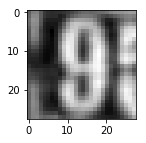

9


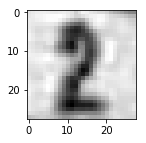

2


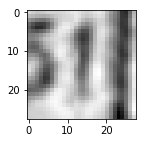

1


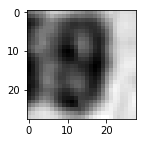

9


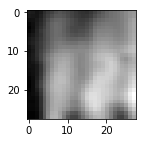

2


In [18]:
import numpy as np

plt.figure(figsize=(2,2))
plt.imshow(x_test[3].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[3].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[2].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[2].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[33].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[33].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[59].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[59].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[100].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[100].reshape(1,28,28,1))))

# Saving the CNN

<h4>Save the trained weights and model in h5 files</h4> 

In [19]:
#Set the path where you want to store the model and weights. 
model.save('/content/gdrive/My Drive/Colab Notebooks/Backup/cnn_svhn.h5')
model.save_weights('/content/gdrive/My Drive/Colab Notebooks/Backup/cnn_svhn_weights.h5')